In [1]:
!pip install pyspark==3.5.0 pyarrow pandas matplotlib sqlalchemy psycopg2-binary

Spark Data processing completed! Preparing to write to the database....
✅ Success! The data has been stored in the database table 'chipotle_market_analysis'.

Preview of the data read from the database：
      region     brand  review_share_pct  avg_stars
0    Midwest     Qdoba              46.9       2.60
1    Midwest  Chipotle              38.6       2.80
2    Midwest      Moes              14.5       3.44
3  Northeast  Chipotle              69.2       2.16
4  Northeast     Qdoba              16.8       3.13


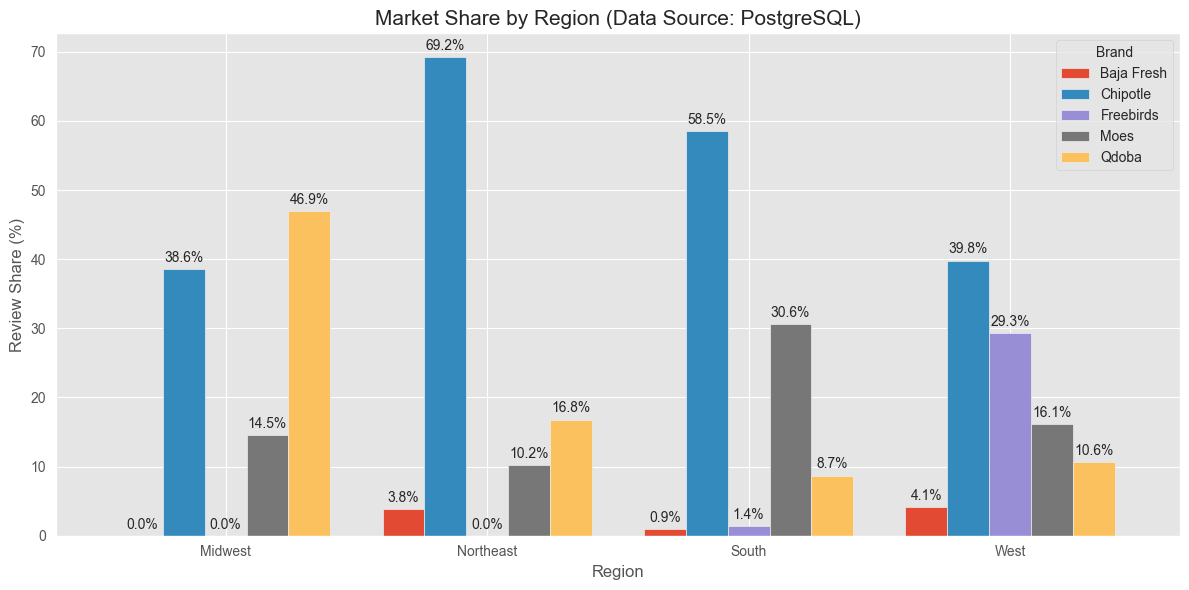

In [2]:
# ==========================================
# Set up environment and clean data (PySpark)
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from sqlalchemy import create_engine

# 1. initialize Spark
spark = SparkSession.builder.appName("Chipotle Analysis Complete").getOrCreate()

# 2. read data
business_path = "yelp_academic_dataset_business.json"
try:
    df_business = spark.read.json(business_path)
except Exception as e:
    print(f"Error：can't find {business_path}.Please check file path.")
    raise e

# 3. Filter：only USA restaurant
df_us = df_business.filter(F.col("state").isNotNull())
df_us_rest = df_us.filter(F.col("categories").contains("Restaurants"))

# 4. Get Brand (Chipotle, Qdoba, Moes)
df_chains = (
    df_us_rest
    .withColumn("name_lower", F.lower("name"))
    .withColumn(
        "brand",
        F.when(F.col("name_lower").like("%chipotle%"), "Chipotle")
         .when(F.col("name_lower").like("%qdoba%"), "Qdoba")
         .when(F.col("name_lower").like("%moe%"), "Moes")
         .when(F.col("name_lower").like("%baja fresh%"), "Baja Fresh")
         .when(F.col("name_lower").like("%freebirds%"), "Freebirds")
         .otherwise(None)
    )
    .drop("name_lower")
).filter(F.col("brand").isNotNull())

# 5. Define regions
northeast = ["ME", "NH", "VT", "MA", "RI", "CT", "NY", "NJ", "PA"]
midwest   = ["OH", "IN", "IL", "MI", "WI", "MN", "IA", "MO", "ND", "SD", "NE", "KS"]
south     = ["DE", "MD", "DC", "VA", "WV", "NC", "SC", "GA", "FL", "KY", "TN", "MS", "AL", "OK", "TX", "AR", "LA"]
west      = ["MT", "ID", "WY", "CO", "NM", "AZ", "UT", "NV", "WA", "OR", "CA", "AK", "HI"]

df_chains_region = (
    df_chains
    .withColumn(
        "region",
        F.when(F.col("state").isin(northeast), "Northeast")
         .when(F.col("state").isin(midwest),   "Midwest")
         .when(F.col("state").isin(south),     "South")
         .when(F.col("state").isin(west),      "West")
         .otherwise(None)
    )
).filter(F.col("region").isNotNull())

# 6. Calculate each indicators
df_brand_region_summary = (
    df_chains_region
    .groupBy("brand", "region")
    .agg(
        F.count("*").alias("store_count"),
        F.avg("stars").alias("avg_stars"),
        F.sum("review_count").alias("total_reviews")
    )
)

# 7. Calculate market share (review)
window_by_region = Window.partitionBy("region")
df_brand_region_with_share = (
    df_brand_region_summary
    .withColumn("region_total_reviews", F.sum("total_reviews").over(window_by_region))
    .withColumn("review_share_pct", F.round(100.0 * F.col("total_reviews") / F.col("region_total_reviews"), 1))
    .withColumn("avg_stars", F.round("avg_stars", 2))
    .orderBy("brand", "region")
)

print("Spark Data processing completed! Preparing to write to the database....")

# ==========================================
# Step 2：Database integration and visualization (SQL Technique)
# ==========================================

# 1. DBs
DB_USER = "postgres"
DB_PASS = "123"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "my_db1_9_2"

connection_str = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
try:
    engine = create_engine(connection_str)

    pdf_results = df_brand_region_with_share.toPandas()
    pdf_results.to_sql('chipotle_market_analysis', engine, index=False, if_exists='replace')
    print(f"✅ Success! The data has been stored in the database table 'chipotle_market_analysis'.")

    # 3. Query data using SQL
    sql_query = """
        SELECT region, brand, review_share_pct, avg_stars
        FROM chipotle_market_analysis
        WHERE region IS NOT NULL
        ORDER BY region, review_share_pct DESC
    """
    df_from_sql = pd.read_sql(sql_query, engine)
    print("\nPreview of the data read from the database：")
    print(df_from_sql.head())

    # 4. Plot
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(12, 6))

    # Data pivot for drawing diagrams
    pivot_data = df_from_sql.pivot(index='region', columns='brand', values='review_share_pct')
    pivot_data.plot(kind='bar', ax=ax, width=0.8)

    ax.set_title('Market Share by Region (Data Source: PostgreSQL)', fontsize=15)
    plt.savefig('market_share_sql_plot.png', dpi=300, bbox_inches='tight')
    ax.set_ylabel('Review Share (%)', fontsize=12)
    ax.set_xlabel('Region', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Brand')

    # Add digital labels
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%', padding=3)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\n❌ Database connection or write failed.")
    print("lease check: 1. Whether the JDBC Driver is installed. 2. Whether the password is correct. 3 Is the database name correct")
    print(f"Detailed error information: {e}")

In [3]:
!pip install pyecharts

In [4]:
!pip install snapshot-selenium

In [5]:
import pandas as pd
from pyecharts.charts import Scatter, Bar
from pyecharts import options as opts

# -------------------------------------------------------
# Make sure the data is arranged in the order (West -> Midwest -> South -> Northeast)
region_order = ["West", "Midwest", "South", "Northeast"]
brands = ["Chipotle", "Qdoba", "Moes", "Baja Fresh", "Freebirds"]

# -------------------------------------------------------
# Chart 1: Scatter bubble diagram (Review Share by Region)
# -------------------------------------------------------

scatter = Scatter()
scatter.add_xaxis(region_order)

# Obtain the maximum and minimum values for bubble size mapping
min_share = df_from_sql['review_share_pct'].min()
max_share = df_from_sql['review_share_pct'].max()

for b in brands:
    # Filter the data of this brand from the SQL data
    sub_df = df_from_sql[df_from_sql['brand'] == b].set_index('region')

    # Construct Y-axis data: Extract review_share_pct in the order of region_order
    # If the brand does not exist in a certain area, fill in 0
    y_data = [
        float(sub_df.loc[r, 'review_share_pct']) if r in sub_df.index else 0.0
        for r in region_order
    ]

    scatter.add_yaxis(
        series_name=b,
        y_axis=y_data,
        label_opts=opts.LabelOpts(
            is_show=True,
            formatter="{c}%",
            position="right" #  Place the label on the right to prevent obstruction
        ),
    )

scatter.set_global_opts(
    title_opts=opts.TitleOpts(title="Review share by region (bubble size = share)"),
    xaxis_opts=opts.AxisOpts(name="Region", type_="category"),
    yaxis_opts=opts.AxisOpts(name="Review share (%)", max_=100),
    legend_opts=opts.LegendOpts(pos_left="right"),
    # VisualMap controls the size of the bubbles
    visualmap_opts=opts.VisualMapOpts(
        type_="size",
        min_=min_share,
        max_=max_share,
        range_size=[10, 60] # The minimum size of the bubbles is 10px and the maximum is 60px
    ),
    tooltip_opts=opts.TooltipOpts(formatter="{a}<br/>Region: {b}<br/>Share: {c}%")
)

# Render in the Notebook
scatter.render_notebook()

In [6]:
# -------------------------------------------------------
# Chart 2: Bar Chart (Average Rating)
# -------------------------------------------------------

bar = Bar()
bar.add_xaxis(region_order)

for b in brands:
    # Filter from SQL data
    sub_df = df_from_sql[df_from_sql['brand'] == b].set_index('region')

    # Construct Y-axis data: avg_stars is extracted
    y_data = [
        float(sub_df.loc[r, 'avg_stars']) if r in sub_df.index else 0.0
        for r in region_order
    ]

    bar.add_yaxis(
        series_name=b,
        y_axis=y_data,
        label_opts=opts.LabelOpts(is_show=True, position="top")
    )

bar.set_global_opts(
    title_opts=opts.TitleOpts(title="Average Yelp rating by brand and region"),
    xaxis_opts=opts.AxisOpts(name="Region"),
    yaxis_opts=opts.AxisOpts(name="Average rating", max_=5), # 评分最高是5
    legend_opts=opts.LegendOpts(pos_left="right"),
    tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="shadow")
)

# Render in the Notebook
bar.render_notebook()

In [7]:
from pyecharts.render import make_snapshot
from snapshot_selenium import snapshot

make_snapshot(snapshot, scatter.render(), "scatter_sql.png")

make_snapshot(snapshot, bar.render(), "bar_sql.png")

print("The picture has been saved.")

The picture has been saved.


In [8]:
!pip install pymongo

In [9]:
# ==========================================
# ETL : Processing unstructured data (Reviews) -> Storing in MongoDB
# ==========================================
import pymongo
import pandas as pd
from pyspark.sql import functions as F

# 1. MongoDB

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["yelp_analysis_db"]  # Create a new library specifically for the data of this Project
collection = db["reviews"]       # Create a new collection to place comments

# 2. Read Review
df_review_raw = spark.read.json("yelp_academic_dataset_review.json")

# 3. Filter
# Logic: We only care about the comments of Chipotle, Qdoba and Moes
# Suppose df_chains is the DataFrame containing three brand stores that you have already generated in your previous code
# If df_chains cannot be found, re-run the previous code that generated df_chains
df_target_reviews = df_review_raw.join(
    df_chains_region.select("business_id", "brand", "region"),
    on="business_id",
    how="inner"
)

# 4. Sampling
# Comment data is usually very large. To demonstrate Flask, we don't need millions
# Here we directly take the first 2,000 items by time
print("Comment data is being filtered and sampled...")
df_reviews_sample = (
    df_target_reviews
    .select("review_id", "brand", "region", "stars", "text", "date", "useful")
    .orderBy(F.col("date").desc()) # Get Latest Update
    .limit(2000)                   # Limit 2000 comments
)

# 5. Load
print("Data is being converted and written to MongoDB...")
pdf_reviews = df_reviews_sample.toPandas()

# Convert to a dictionary list
records = pdf_reviews.to_dict("records")

# Clear before writing to prevent data accumulation caused by repeated running
collection.drop()
collection.insert_many(records)

print(f"✅ Success! The {len(records)} comment has been written to MongoDB.")
print("Database: yelp_analysis_db, collection: reviews")

Comment data is being filtered and sampled...
Data is being converted and written to MongoDB...
✅ Success! The 2000 comment has been written to MongoDB.
Database: yelp_analysis_db, collection: reviews


In [10]:
# ==========================================
# Advanced Visualization with Pyecharts (Highlighted Style)
# ==========================================

from pyecharts.charts import Scatter, Bar
from pyecharts import options as opts
from pyecharts.commons.utils import JsCode
import pandas as pd

# 1. West -> Midwest -> South -> Northeast
region_order = ["West", "Midwest", "South", "Northeast"]

# 2. Define the style dictionary
chipotle_style = {
    "color": "#d32323",
    "borderColor": "black",
    "borderWidth": 3,
    "shadowBlur": 20,
    "shadowColor": "#00FFFF",
    "opacity": 1.0
}

other_style = {
    "opacity": 0.6,
    "borderWidth": 0,
    "shadowBlur": 0
}

# ==========================================
# Chart 1: Market Share Scatter
# ==========================================
scatter = Scatter()
scatter.add_xaxis(region_order)

# Obtain the maximum and minimum values for bubble size mapping
min_share = df_from_sql['review_share_pct'].min()
max_share = df_from_sql['review_share_pct'].max()

# Sort the brands: Place the Chipotle at the end of the list to prevent it from being blocked
unique_brands = df_from_sql['brand'].unique()
sorted_brands = sorted(unique_brands, key=lambda x: 1 if x == 'Chipotle' else 0)

for b in sorted_brands:
    # Filter the brand's data
    sub_df = df_from_sql[df_from_sql['brand'] == b].set_index('region')

    # Construct Y-axis data
    y_data = [
        float(sub_df.loc[r, 'review_share_pct']) if r in sub_df.index else 0.0
        for r in region_order
    ]

    current_style = chipotle_style if b == 'Chipotle' else other_style

    scatter.add_yaxis(
        series_name=b,
        y_axis=y_data,
        symbol_size=20,
        itemstyle_opts=current_style,
        label_opts=opts.LabelOpts(
            is_show=True,
            formatter=JsCode("function(params){return params.value[1] + '%';}"),
            position="right",
            color="black" if b == "Chipotle" else "grey",
            font_weight="bold" if b == "Chipotle" else "normal"
        ),
    )

scatter.set_global_opts(
    title_opts=opts.TitleOpts(title="Market Share (Chipotle Highlighted)", pos_left="2%"),
    xaxis_opts=opts.AxisOpts(name="Region", type_="category", splitline_opts=opts.SplitLineOpts(is_show=True)),
    yaxis_opts=opts.AxisOpts(name="Review Share (%)", max_=100, splitline_opts=opts.SplitLineOpts(is_show=True)),
    legend_opts=opts.LegendOpts(pos_right="5%", pos_top="5%"),
    visualmap_opts=opts.VisualMapOpts(
        type_="size",
        min_=min_share,
        max_=max_share,
        range_size=[15, 80],
        pos_bottom="10%",
        pos_left="2%",
        range_opacity=0.6
    )
)

# Generate HTML files
scatter.render("highlighted_market_share.html")
print("✅ Chart 1 Generated: highlighted_market_share.html")


# ==========================================
# Chart 2: Average Rating Bar (Highlighted)
# ==========================================
bar = Bar()
bar.add_xaxis(region_order)

for b in sorted_brands:
    sub_df = df_from_sql[df_from_sql['brand'] == b].set_index('region')

    y_data = [
        float(sub_df.loc[r, 'avg_stars']) if r in sub_df.index else 0.0
        for r in region_order
    ]

    current_style = chipotle_style if b == 'Chipotle' else other_style

    bar.add_yaxis(
        series_name=b,
        y_axis=y_data,
        category_gap="30%",
        gap="0%",
        itemstyle_opts=current_style,
        label_opts=opts.LabelOpts(
            is_show=True,
            position="top",
            color="black" if b == "Chipotle" else "grey",
            font_weight="bold" if b == "Chipotle" else "normal"
        )
    )

bar.set_global_opts(
    title_opts=opts.TitleOpts(title="Average Ratings (Chipotle Highlighted)", pos_left="2%"),
    xaxis_opts=opts.AxisOpts(name="Region"),
    yaxis_opts=opts.AxisOpts(name="Rating (1-5)", max_=5),
    legend_opts=opts.LegendOpts(pos_right="5%", pos_top="5%"),
)

# Generate HTML files
bar.render("highlighted_ratings.html")
print("✅ Chart 2 Generated: highlighted_ratings.html")

✅ Chart 1 Generated: highlighted_market_share.html
✅ Chart 2 Generated: highlighted_ratings.html
